# Empirical Data Analysis

We introduce a novel technique to extrapolate/predict the expected number of coverage elements to discover in a fuzzing campaign, if we continue the campaign a bit further.

* **Experiments -** We ran the state-of-the-art greybox fuzzer, AFL++ on multiple subject programs with various number of LoC.

* **Analysis -** In this notebook, we present our novel algorithm on obtained fuzzing data and evaluation of the results against the existing extrapolation technique.


In [1]:
#Required libraries
library(rjson)
library(stringr)
library(jsonlite)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(scales)
library(grid)
library(gridExtra)
library(tidyr)
library(plotly)
library(foreach)
library(doParallel)
library(cowplot)
library(lsr)
library(rstatix)
library(colorspace)

REGENERATE_DATA = FALSE

options(warn=-1) # Supress irrelevant warnings


Attaching package: ‘jsonlite’


The following objects are masked from ‘package:rjson’:

    fromJSON, toJSON



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks jsonlite::flatten()
✖ jsonlite::fromJSON() masks rjson::fromJSON()
✖ dplyr::lag()         masks stats::lag()
✖ jsonlite::toJSON()   masks rjson::toJSON()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘gridExtra’

## Extrapolate coverage for real-world programs

In [2]:
if(REGENERATE_DATA){
    
    unzip("../data/fuzztastic_data.zip",exdir="../data/")
    
    subjects = list.files("../data/fuzztastic_data/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 5
    for(subject in subjects){
        folder = paste("../data/fuzztastic_data/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) # 8 calibration runs.
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "../data/gb_data.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "../data/gb_data.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
        
            for(m in seq(1,length(u_list),4)){
                dis_prob = tibble()
                cores = 8 #detectCores()
                cl = makeCluster(cores[1]-1,type = "FORK")
                registerDoParallel(cl)
                ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                ## To get more estimates, repeat this several times (i.e. # of repetitions)
                dis_prob = foreach(rep=1:n_reps, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                   filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                   if(RESET){
                       cut_pt = round(exp(seq(log(1),log(m),length=10))[9])
                       filtered = filtered %>% filter(theta>=cut_pt)
                   }else{
                       cut_pt = 0
                   }
                   theta_list = filtered$theta
                   filtered = filtered %>% select(-theta)
                   shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                   filtered = filtered[shuffle_order,]
                   filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                   f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                   f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                   sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                   rm(list = c("filtered"))
                   tibble(subject=subject,run=run,repetition=rep,time_n0=timestamps[m],time=timestamps[cut_pt:m],
                               n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,start=cut_pt,theta0=m,f1=f1,f2=f2,
                               gt=(f1/theta),sn=sn,s=length(bb_ids))
                }
                
                if(sub2==1){
                    write.table(dis_prob, file = "../data/bb_data.csv", row.names = FALSE,quote = FALSE)
                    sub2 = sub2 + 1
                }else{
                    write.table(dis_prob, file = "../data/bb_data.csv",
                    append = TRUE, quote = FALSE,
                    col.names = FALSE, row.names = FALSE)
                }
                stopCluster(cl)
                gc()
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("../data/gb_data.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>% 
                rename(f1_gb=f1,f2_gb=f2)
    save(gb_data,file="../data/gb_data.Rdata")
    
    bb_data = read.table("../data/bb_data.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    colnames(bb_data)[4] = "timestamp"
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    save(bb_data,file="../data/bb_data.Rdata")
} else{
    ## Loading saved data
    load(file="../data/gb_data.Rdata")
    load(file="../data/bb_data.Rdata")
}                       


### Perform extrapolation using novel and existing techniques

We perform linear extrapolation based on our proposed appeoach using the populated coverage rate estimates for historical data. Also we predict the coverage rates using existing technique as well.

In [3]:
## Perform Extrapolation
if(REGENERATE_DATA){
    
    ## Existing extrapolator
    hat_snm = function(f1,f2,theta,m){
        f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
        est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
        est = ifelse(is.nan(est),0,est)
        return(est)
    }

    ########################################
    # Filter a random run
    init = 1
    train_data = tibble()
    t0_list = seq(50,max(gb_data$theta),by=50)
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            # Filter required data
            bb_df = bb_data %>% filter(run==trial) %>% filter(subject==sub)
            gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
            for(t0 in t0_list){
                
                ######################################
                reg_df = bb_df %>% filter(theta0<=t0)
                
                tryCatch({
                # Only to get most recent points as training
                train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                      log(max((reg_df %>% filter(theta>0))$theta0)),length=10))[9]
                reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
        
                reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                reg_df = reg_df %>% drop_na()
                model = lm(log(gt)~log(theta),data = reg_df)
                slope = model$coefficient[2]
                intercept = model$coefficient[1]
                
                ######################################
                predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                predict_df = predict_df %>% mutate(gt_gb=f1_gb/theta)
                f1_gb = predict_df$f1_gb[1]
                f2_gb = predict_df$f2_gb[1]
                theta0 = predict_df$theta[1]
                #u0 = predict_df$u[1]
                extra_df = tibble()
                for(prop in proportions){
                    m = round(prop*t0)
                    if(nrow(predict_df)<m){
                    m = nrow(predict_df)
                    }
                    delta_existing=as.numeric(lapply(1:m, function(x) hat_snm(f1_gb,f2_gb,theta0,x)))
                    delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                
                    extra_df = rbind(extra_df,
                                     tibble(subject=sub,run=trial,theta0=t0,prop=prop,theta=seq(max(reg_df$theta),length=m),
                                        delta_existing=delta_existing,delta_new=delta_new,
                                        sn_gb=predict_df$sn_gb[1:m],gt_gb=predict_df$gt_gb[1:m]))
                            
                }
                                         
                if(init==1){
                   write.table(extra_df, file = "../data/extrapolated.csv", row.names = FALSE,quote = FALSE)
                   init = init + 1
                }else{
                   write.table(extra_df, file = "../data/extrapolated.csv",
                   append = TRUE, quote = FALSE,
                   col.names = FALSE, row.names = FALSE)
                }
                                             
                train_data = rbind(train_data,reg_df)
                
                }, error=function(e){})
            }
        }
    }
    ## Save gathered data as R objects for future use
    extrapolated = read.table("../data/extrapolated.csv",header=T)
    save(extrapolated,file="../data/extrapolated.Rdata")

    save(train_data,file="../data/train_data.Rdata")
}else{
    ## Loading saved data
    load(file="../data/extrapolated.Rdata")
    load(file="../data/train_data.Rdata")
}


### Data cleaning

In [4]:
# Filter out outlying runs
exclude_runs = unique((gb_data %>% filter(subject=="jasper" & sn_gb>5000))$run)
gb_data = gb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
bb_data = bb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
extrapolated = extrapolated %>% filter(!(subject=="jasper" & run %in% exclude_runs))
train_data = train_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))

In [5]:
# Smoothing singleton (f1) and doubleton (f1) counts to make existing extrapolation possible
smooth_bb_df = bb_data %>%
                group_by(subject,run,theta) %>%
                summarise_at(vars(-c(repetition,theta0)),mean,na.rm=TRUE) %>%
                mutate(smooth_f1_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f2_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f1_gb=ifelse(smooth_f1_gb<0,0,smooth_f1_gb),
                       smooth_f2_gb=ifelse(smooth_f2_gb<0,0,smooth_f2_gb)) %>%
                select(subject,run,theta,smooth_f1_gb,smooth_f2_gb) %>%
                rename(theta0=theta)

extrapolated = merge(extrapolated,smooth_bb_df,by=c("subject","run","theta0"),all.x=TRUE)

## Existing extrapolator
hat_snm = function(f1,f2,theta,m){
    f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
    est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
    est = ifelse(is.nan(est),0,est)
    return(est)
}

# Recompute existing extrapolation using smooth data
extrapolated = extrapolated %>%
            mutate(delta_existing=as.numeric(hat_snm(smooth_f1_gb,smooth_f2_gb,theta0,(theta-theta0))))

head(extrapolated)

,subject,run,theta0,prop,theta,delta_existing,delta_new,sn_gb,gt_gb,smooth_f1_gb,smooth_f2_gb
,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,freetype2,1,50,2.0,141,0.1222157,0.5995232,6466,0.7517730,232.8841,232.8841
2,freetype2,1,50,2.0,142,0.1174229,0.5919147,6466,0.7394366,232.8841,232.8841
3,freetype2,1,50,1.5,120,0.2831281,0.8022364,6439,1.6166667,232.8841,232.8841
4,freetype2,1,50,3.0,68,2.2669191,2.2298201,6219,3.5441176,232.8841,232.8841
5,freetype2,1,50,1.5,119,0.2946844,0.8144453,6417,1.5042017,232.8841,232.8841
6,freetype2,1,50,2.0,128,0.2055844,0.7139998,6455,1.0156250,232.8841,232.8841


### Compute ground-truth

In [6]:
# Bootstrap-based approach
if(REGENERATE_DATA){
   common_theta = min((gb_data %>% group_by(subject,run) %>% summarise(max_theta = max(theta)))$max_theta)
   gb_data = gb_data %>% filter(theta<=common_theta)
   
   n_boot = 100
   gb_boot = tibble()
   for(sub in unique(gb_data$subject)){
       gb_df = gb_data %>% filter(subject==sub)
       for(i in 1:n_boot){
           boot_run = sample(unique(gb_df$run),length(unique(gb_df$theta)),replace=TRUE)
           sn_gb = c()
           theta_select = min(unique(gb_df$theta))
           theta = c()
           for(trial in boot_run){
               sn_gb = c(sn_gb,(gb_df %>% filter(run==trial,theta==theta_select))$sn_gb)
               theta = c(theta,theta_select)
               theta_select = theta_select + 1
           }
           gb_boot = rbind(gb_boot,tibble(subject=sub,boot_id=i,theta=theta,sn_gb=sn_gb))
       }
   }
   
   # Compute the ground-truth using smoothen species richness curve
   gt_data = gb_boot %>%
                   group_by(id) %>%
                   mutate(smooth_gb = predict(loess(sn_gb ~ theta, span=0.05))) %>%
                   ungroup()%>%
                   group_by(theta) %>%
                   summarise(mean_sn=mean(smooth_gb)) %>%
                   arrange(theta) %>%
                   mutate(ground=c(NA,diff(mean_sn))) %>%
                   ungroup() 
}else{
    load(file="../data/gt_data.Rdata")
}

### Showcase extrapolation performance

In [7]:
## Showcase an extrapolation scenario for a given subject
selected_sub = "freetype2"
selected_t0 = 350
                            
train_df = train_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>% 
                    mutate(train_limit=exp(seq(log(min(theta)),
                                      log(max(theta0)),length=10))[8]) %>% 
                    filter(theta>=train_limit) %>% 
                    group_by(run) %>% 
                    mutate(keep=ifelse((selected_t0-max(theta))>5,0,1)) %>%
                    filter(keep==1)

extra_df = extrapolated %>% filter(subject==selected_sub) %>% 
                    filter(theta0<=selected_t0) %>% filter(theta0==max(theta0)) %>% 
                    filter(prop==1) %>% 
                    filter(run %in% unique(train_df$run))

bb_df = bb_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>%  
                    filter(run %in% unique(train_df$run))

gb_df = gb_data %>% filter(subject==selected_sub) %>% 
                    filter(run %in% unique(train_df$run))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


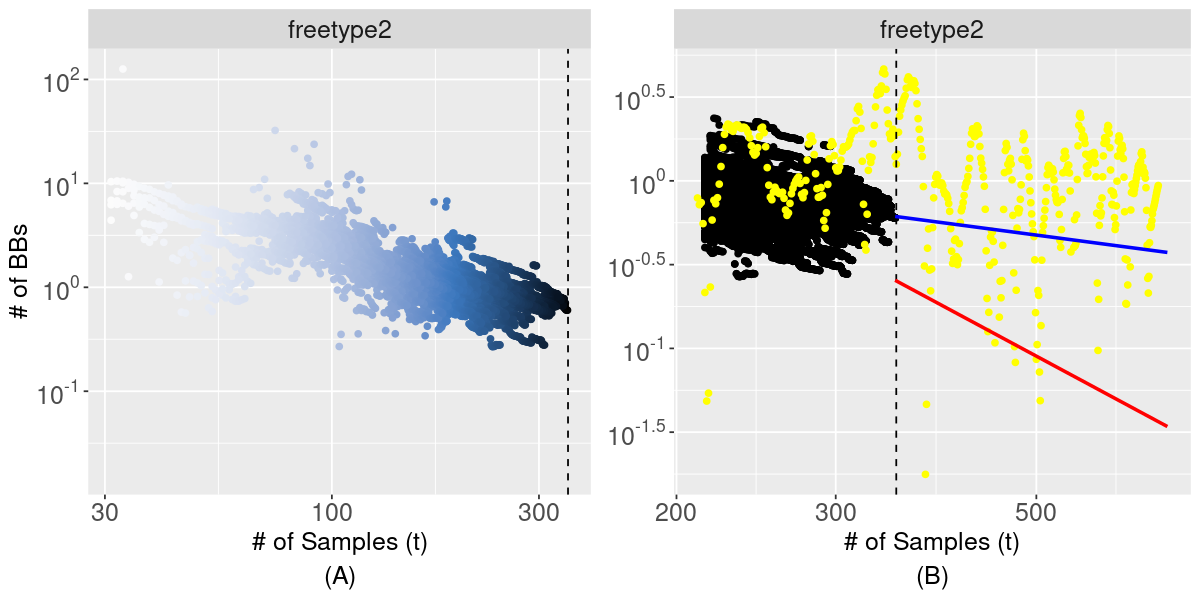

In [8]:
options(repr.plot.width = 10, repr.plot.height = 5)
p1 = ggplot() +
      geom_point(data=bb_df %>% arrange(-theta0) %>% filter(theta>30,gt>0,theta0<=selected_t0,run==1,repetition==1) %>% 
                 mutate(gt=f1/theta),
                 aes(theta,gt,,color=theta)) +
      geom_vline(xintercept=selected_t0,linetype="dashed") +
      scale_x_log10("# of Samples (t)") +
      scale_y_log10("# of BBs",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x)),limits=c(10^(-1.8),NA)) +
      labs(caption = "(A)") +
      scale_color_gradientn(colors = hcl.colors(40, "Oslo", rev = FALSE)) +
      theme(plot.caption = element_text(hjust=0.5,size=15),legend.position="none",
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=15),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=15),
         legend.text=element_text(size=15),
         strip.text.x = element_text(size=15),strip.text.y = element_text(size=15)) +
      facet_wrap(.~subject,ncol=5,scales="free")

p2 = ggplot() +
      geom_point(data=train_df %>% filter(theta>100,gt>0,run==1),aes(theta,gt)) +
      geom_point(data=gt_data %>% filter(theta>210,theta<=(2*selected_t0),subject==selected_sub),aes(theta,ground),se=T,color="yellow") +
      #geom_smooth(data=train_df %>% filter(theta>30,theta<=selected_t0,gt>0,run==1),aes(theta,gt),se=F,method="lm") +
      geom_vline(xintercept=selected_t0,linetype="dashed") +
      geom_smooth(data=extra_df %>% filter(theta>30,run==1),aes(theta,delta_existing),color="red",se=F,method="lm") +
      labs(caption = "(B)") +
      geom_smooth(data=extra_df %>% filter(theta>30,run==1),aes(theta,delta_new),color="blue",se=F,method="lm") +
      theme(axis.title.y = element_blank(),plot.caption = element_text(hjust=0.5,size=15),
           axis.text.x=element_text(size=15),axis.title.x=element_text(size=15),
           axis.text.y=element_text(size=15),
           legend.text=element_text(size=15),
           strip.text.x = element_text(size=15)) +
      scale_x_log10("# of Samples (t)") +
      scale_y_log10("# of BBs at t U(t)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
      facet_wrap(.~subject,ncol=5,scales="free")

g = grid.arrange(p1, p2, nrow = 1)
ggsave(file="../figures/Figure-3.png",g,width = 10, height = 5, units = "in", device='png')

### RQ 1 - Extrapolator Performance for Short-Term Prediction Horizons

We consider predicting the half of current campaign length into the future (i.e.m=0.5*t0) at various points (t0) in the fuzzing campaigns.

In [9]:
## Extrapolation for all the subjects for a given horizon (m)
selected_prop = 0.5

extra_df = tibble()
train_df = tibble()
bb_df = tibble()

for(selected_t0 in seq(200,500,by=50)){
    extra_temp = extrapolated %>% filter(theta>100) %>% 
                    filter(theta0==selected_t0,theta>=selected_t0,prop==selected_prop) %>%
                    group_by(subject,run) %>%
                    filter(first(delta_existing)!=0)
                            
    train_temp = train_data %>% filter(theta>100) %>% 
                                filter(theta0<=selected_t0) %>% 
                                mutate(train_limit=exp(seq(log(min(theta)),
                                          log(max(theta0)),length=10))[9]) %>% filter(theta0>=train_limit) %>% 
                    filter(run %in% unique(extra_temp$run)) %>%
                    group_by(subject,theta0,theta) %>% 
                    summarize_at(vars(c(-run,-repetition)),mean, na.rm = TRUE) %>% 
                    ungroup()
    
    bb_temp = bb_data %>% filter(theta>100) %>% filter(theta0<=selected_t0) %>% 
                    filter(run %in% unique(extra_temp$run)) %>%
                    group_by(subject,theta,theta0) %>% summarize_at(vars(-run),mean, na.rm = TRUE) %>%
                    ungroup() %>%
                    mutate(theta0=selected_t0)
    
    extra_df = rbind(extra_df,as.data.frame(extra_temp))
    train_df = rbind(train_df,as.data.frame(train_temp))
    bb_df = rbind(bb_df,as.data.frame(bb_temp))
}

extra_df = merge(extra_df,gt_data,by=c("subject","theta"),all.x=TRUE)

`summarise()` has grouped output by 'subject', 'run', 'theta0'. You can
override using the `.groups` argument.


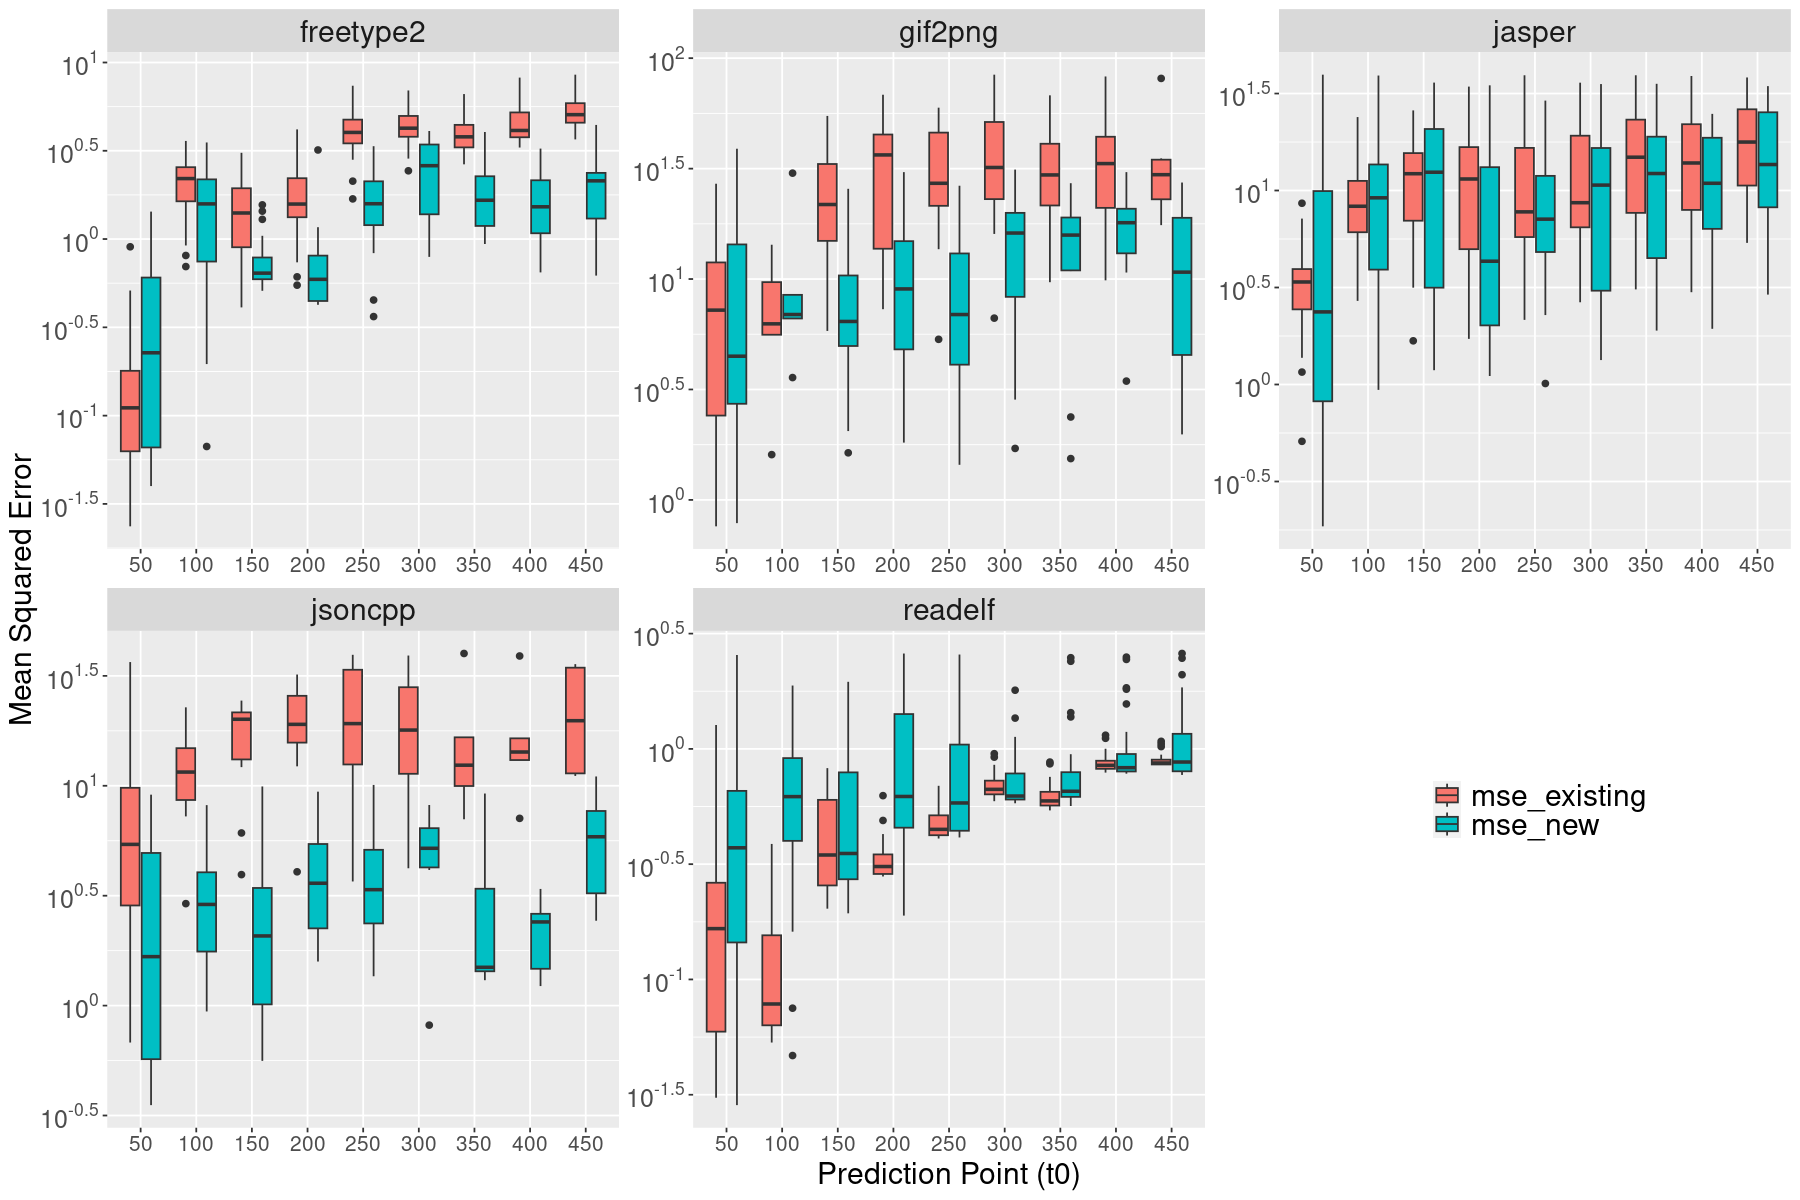

In [10]:
## Compute Mean Squared Error
mse_result = extrapolated %>% 
            filter(delta_existing>0 | delta_new>0) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new)) %>%
            merge(gt_data %>% filter(ground>0) %>% mutate(ground=log(ground)),by=c("subject","theta"),all.x=TRUE) %>%
            drop_na() %>% 
            filter_all(all_vars(!is.infinite(.))) %>%
            group_by(subject,run,theta0,prop) %>%
            summarize(mse_existing=mean((delta_existing-ground)^2),mse_new=mean((delta_new-ground)^2)) %>%
            ungroup()

mse_result = mse_result %>%
                filter((theta0+prop*theta0)<=max(theta0)) %>%
                group_by(subject,theta0,prop) %>%
                pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
                ungroup() %>%
                filter(prop==selected_prop)

options(repr.plot.width = 15, repr.plot.height = 10)

mse_result %>%
filter(method=="mse_existing" | method=="mse_new") %>%
mutate(theta0=factor(theta0)) %>% 
group_by(subject,method) %>%
filter(value<as.numeric(quantile(value,0.75)[1])+IQR(value)*1.5) %>%
ungroup() %>%
ggplot() +
geom_boxplot(aes(x=theta0,y=value,fill=method)) +
theme(axis.title.x = element_text(size=18), legend.title = element_blank(),legend.position = c(0.85,0.3),
 legend.text=element_text(size=18),
 axis.text.x=element_text(size=12.5),
 axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
 strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
scale_y_log10("Mean Squared Error",
    breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x))) + 
facet_wrap(~subject,ncol=3,scales="free") +
xlab("Prediction Point (t0)")

ggsave("../figures/Figure-4.pdf",width=15,height=10)

`summarise()` has grouped output by 'subject', 'theta0'. You can override using
the `.groups` argument.


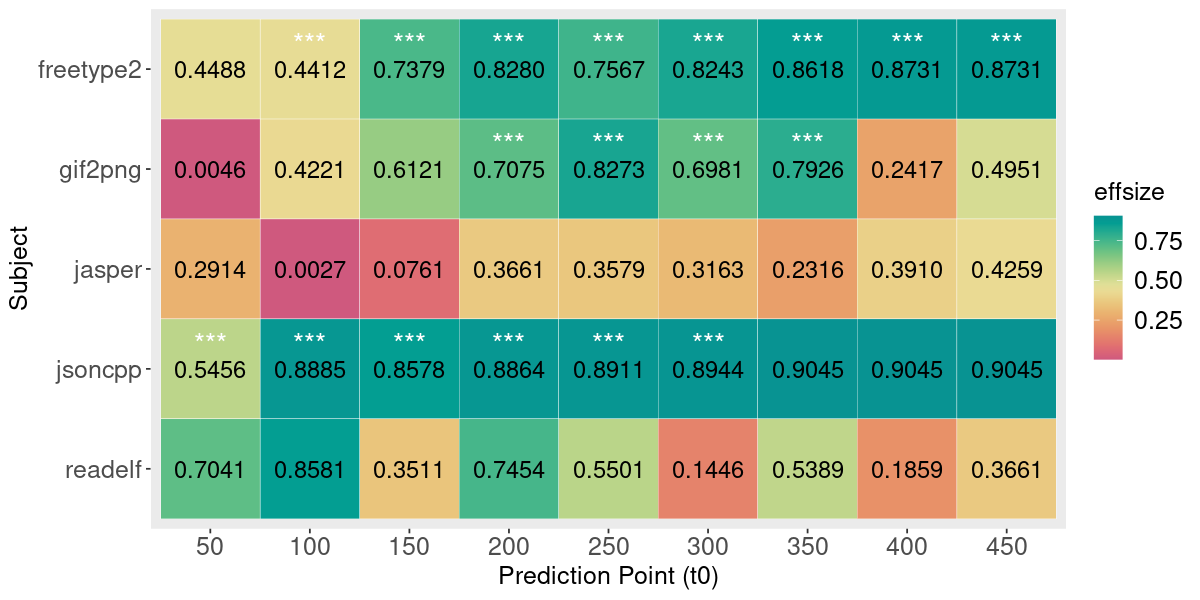

In [11]:
eff_size = merge(
            mse_result %>%
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            distinct() %>%
            group_by(subject,theta0,prop) %>%
            wilcox_effsize(value ~ method,alternate="greater",paired = TRUE,conf.level=0.99) %>%
            ungroup() %>%
            select(subject,theta0,prop,effsize),
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            distinct() %>%
            group_by(subject,theta0,prop) %>%
            summarise(p.value=wilcox.test(value ~ method,alternative="greater",paired = TRUE,conf.level=0.99)$p.value) %>%
            ungroup(),
            by=c("subject","theta0","prop"))

eff_size$theta0 = factor(eff_size$theta0, levels=seq(50,max(gb_data$theta),by=50))
eff_size$prop = factor(eff_size$prop, levels=c(0.5))
eff_size$subject = factor(eff_size$subject, levels=c("readelf","jsoncpp","jasper","gif2png","freetype2"))

options(repr.plot.width = 10, repr.plot.height = 5)
pp = eff_size %>%
    rename(t0=theta0,proportion=prop) %>%
    ggplot(aes(x = t0, y = subject, fill = effsize)) +
    geom_tile(color="white") +
    geom_text(aes(label = format(effsize, scientific = FALSE, digits = 2)), color = "black", size = 5) +
    geom_text(aes(label = ifelse(p.value<=0.01,"***","")), color = "white", size = 6, vjust = -0.7) +
    scale_fill_gradientn(colors = hcl.colors(20, "Temps", rev=TRUE)) +
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
         axis.text.x=element_text(size=15),strip.text.x = element_text(size=15),
         axis.title.x=element_text(size=15),strip.text.y = element_text(size=15),
         axis.text.y=element_text(size=15),
         axis.title.y=element_text(size=15),
         legend.text=element_text(size=15),
         legend.title=element_text(size=15)) +
    ylab("Subject") + 
    xlab("Prediction Point (t0)")

pp
ggsave("../figures/Figure-5.pdf",width=10,height=5)

### RQ 2 - Impact of Prediction Horizon on Extrapolator Performance

In [12]:
## Extrapolation for all the subjects
selected_t0 = 250

extra_df = extrapolated %>% filter(theta>100) %>% 
                    filter(theta0==selected_t0,theta>=selected_t0) %>%
                    group_by(subject,run,prop) %>%
                    filter(first(delta_existing)!=0)
                            
train_df = train_data %>% filter(theta>100) %>% 
                            filter(theta0<=selected_t0) %>% 
                            mutate(train_limit=exp(seq(log(min(theta)),
                                      log(max(theta0)),length=10))[9]) %>% filter(theta0>=train_limit) %>% 
                filter(run %in% unique(extra_df$run)) %>%
                group_by(subject,theta0,theta) %>% summarize_at(vars(c(-run,-repetition)),mean, na.rm = TRUE) 

bb_df = bb_data %>% filter(theta>100) %>% filter(theta0<=selected_t0) %>% 
                filter(run %in% unique(extra_df$run)) %>%
                group_by(subject,theta,theta0) %>% summarize_at(vars(-run),mean, na.rm = TRUE) 

gb_df = gb_data %>% filter(theta>100) %>% 
                filter(run %in% unique(extra_df$run)) %>%
                group_by(subject,theta) %>% summarize_at(vars(-run),mean, na.rm = TRUE) 


`summarise()` has grouped output by 'subject', 'run', 'theta0'. You can
override using the `.groups` argument.


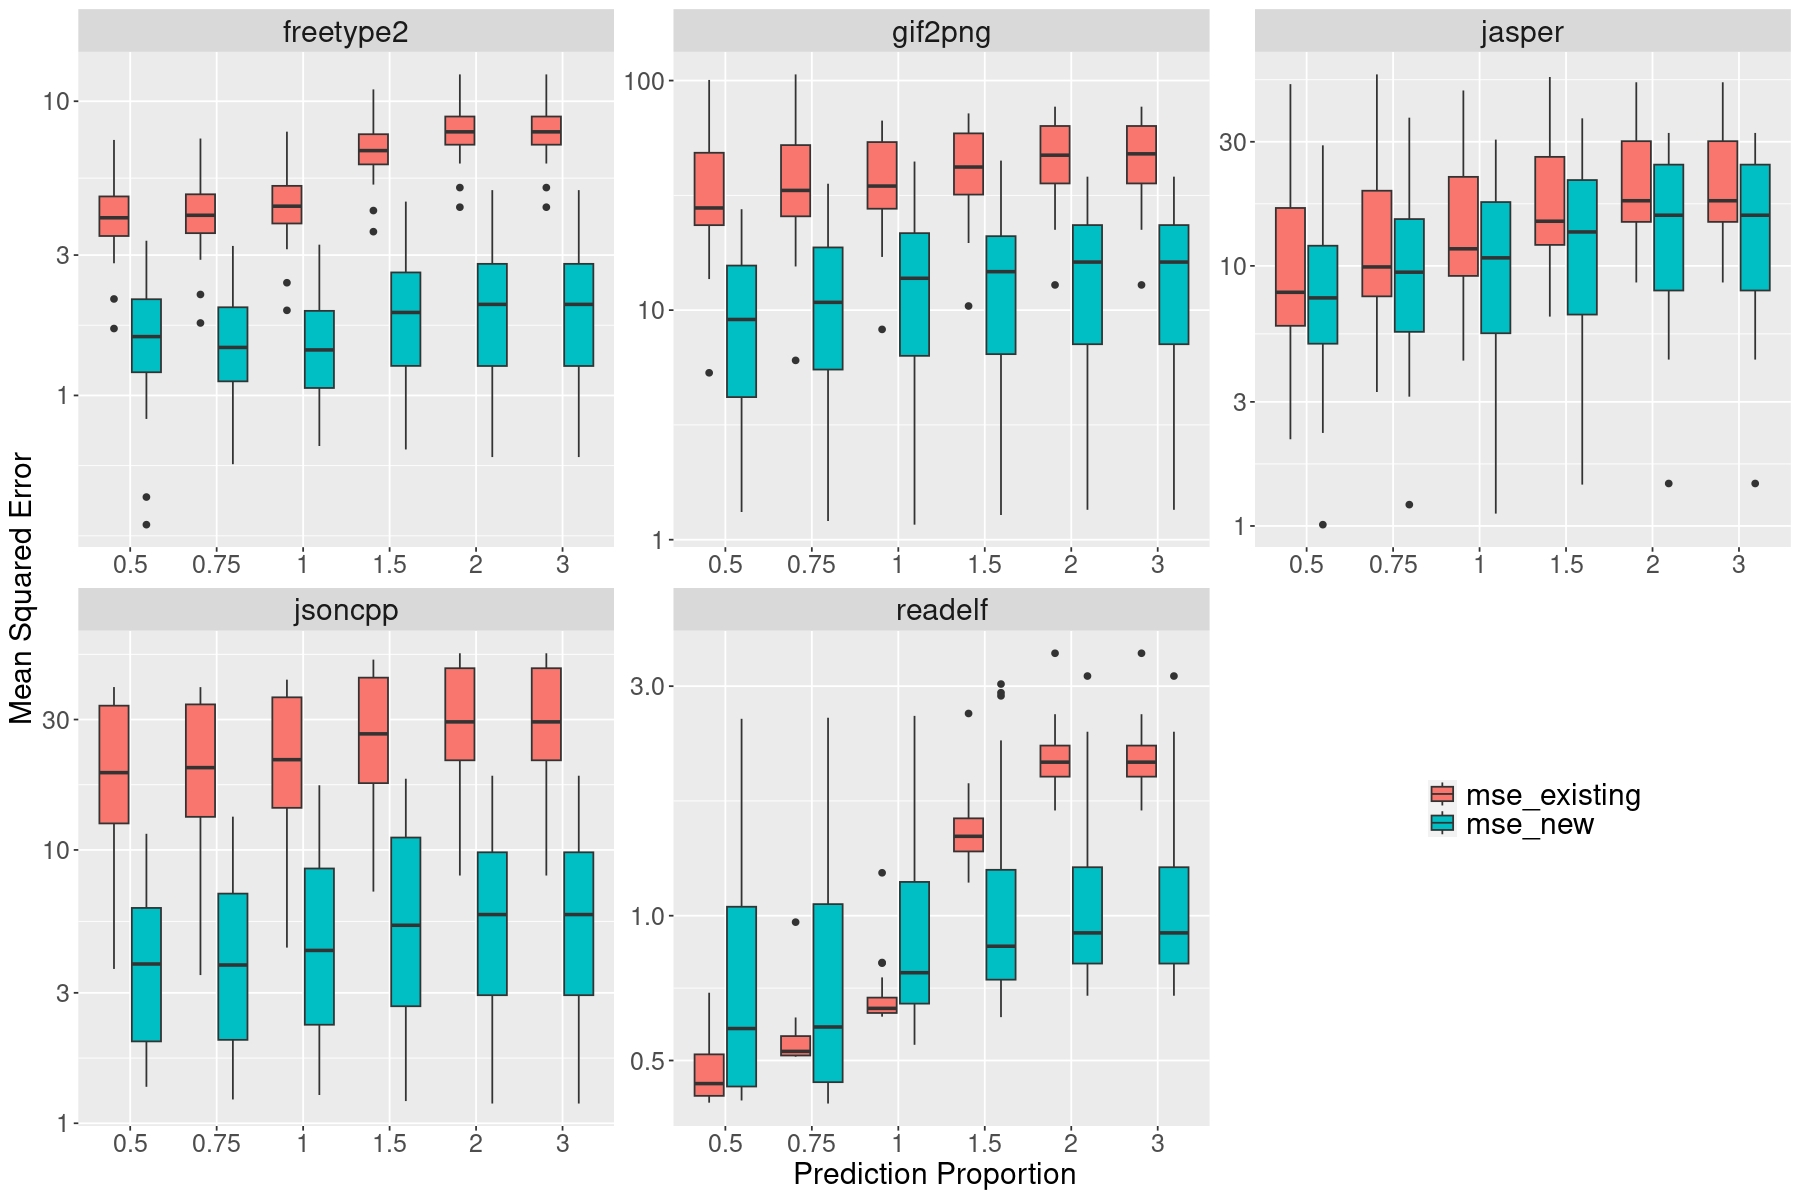

In [13]:
## Compute Mean Squared Error
mse_result = extrapolated %>% 
            filter(delta_existing>0 | delta_new>0,theta0==selected_t0) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new)) %>%
            merge(gt_data %>% filter(ground>0) %>% mutate(ground=log(ground)),by=c("subject","theta"),all.x=TRUE) %>%
            drop_na() %>% 
            group_by(subject,run,theta0,prop) %>%
            summarize(mse_existing=mean((delta_existing-ground)^2),mse_new=mean((delta_new-ground)^2)) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
            ungroup()

options(repr.plot.width = 15, repr.plot.height = 10)

p1 = mse_result %>%
        filter(method=="mse_existing" | method=="mse_new") %>%
        filter_all(all_vars(!is.infinite(.))) %>% 
        arrange(theta0) %>%
        mutate(prop=factor(prop),theta0=factor(paste("t0 = ",theta0,sep=""),c(paste("t0 = ",seq(50,500,by=50),sep="")))) %>%
        group_by(subject,method) %>%
        filter(value<as.numeric(quantile(value,0.75)[1])+IQR(value)*1.5) %>%
        ungroup() %>%
        ggplot() +
        geom_boxplot(aes(x=prop,y=value,fill=method)) +
        labs(x="Prediction Proportion") +
        theme(legend.title = element_blank(),legend.position = c(0.85,0.3),
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=18),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
        scale_y_log10("Mean Squared Error") + 
        facet_wrap(.~subject,ncol=3,scales="free")

plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Figure-6.pdf",width=15,height=10)

`summarise()` has grouped output by 'subject', 'theta0'. You can override using
the `.groups` argument.


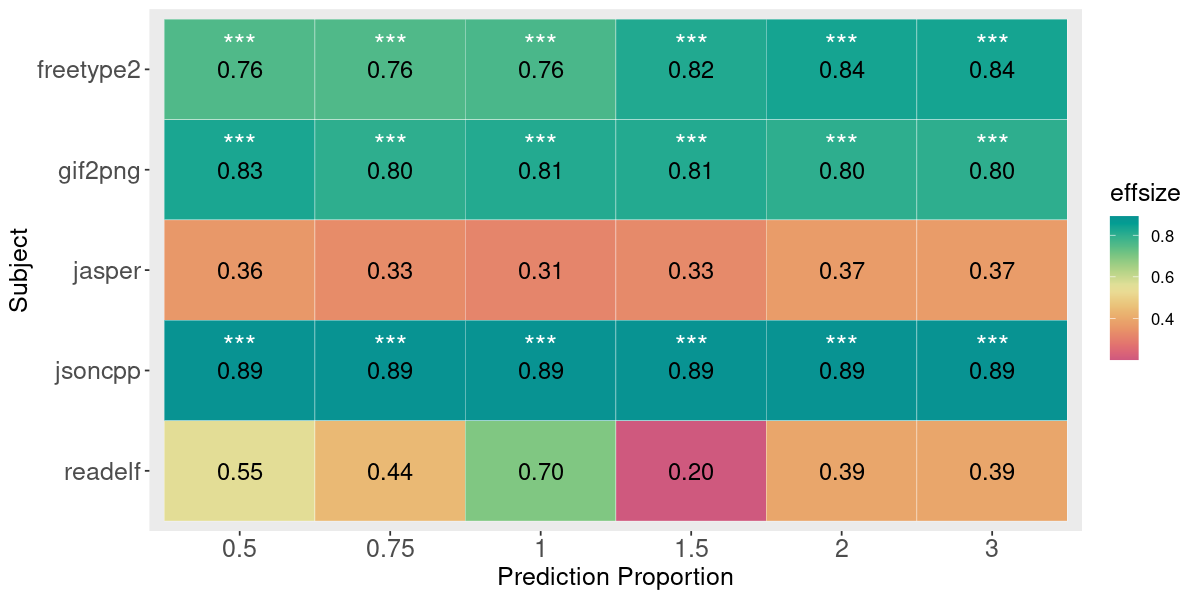

In [14]:
eff_size = merge(
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            wilcox_effsize(value ~ method,alternate="greater",paired = TRUE,conf.level=0.99) %>%
            ungroup() %>%
            select(subject,theta0,prop,effsize),
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            summarise(p.value=wilcox.test(value ~ method,alternative="greater",paired = TRUE,conf.level=0.99)$p.value) %>%
            ungroup(),
            by=c("subject","theta0","prop"))

eff_size$theta0 = factor(eff_size$theta0, levels=seq(50,max(gb_data$theta),by=50))
eff_size$prop = factor(eff_size$prop, levels=c(0.5,0.75,1,1.5,2,3))
eff_size$subject = factor(eff_size$subject, levels=c("readelf","jsoncpp","jasper","gif2png","freetype2"))

options(repr.plot.width = 10, repr.plot.height = 5)
pp = eff_size %>%
    rename(t0=theta0,proportion=prop) %>%
    ggplot(aes(x = proportion, y = subject, fill = effsize)) +
    geom_tile(color="white") +
    geom_text(aes(label = format(effsize, scientific = FALSE, digits = 2)), color = "black", size = 5) +
    geom_text(aes(label = ifelse(p.value<=0.01,"***","")), color = "white", size = 6, vjust = -0.7) +
    scale_fill_gradientn(colors = hcl.colors(20, "Temps", rev=TRUE)) +
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
         axis.text.x=element_text(size=15),strip.text.x = element_text(size=15),
         axis.title.x=element_text(size=15),strip.text.y = element_text(size=15),
         axis.text.y=element_text(size=15),
         axis.title.y=element_text(size=15),
         legend.text=element_text(size=10),
         legend.title=element_text(size=15)) +
    ylab("Subject") + 
    xlab("Prediction Proportion")

plot_grid(pp, ncol = 1, align = "v")
ggsave("../figures/Figure-7.pdf",width=10,height=5)


### RQ 3 - Sensitivity of Horizon (m) and Campaign Length (t0) on Extrapolation Performance

`summarise()` has grouped output by 'subject', 'run', 'theta0'. You can
override using the `.groups` argument.


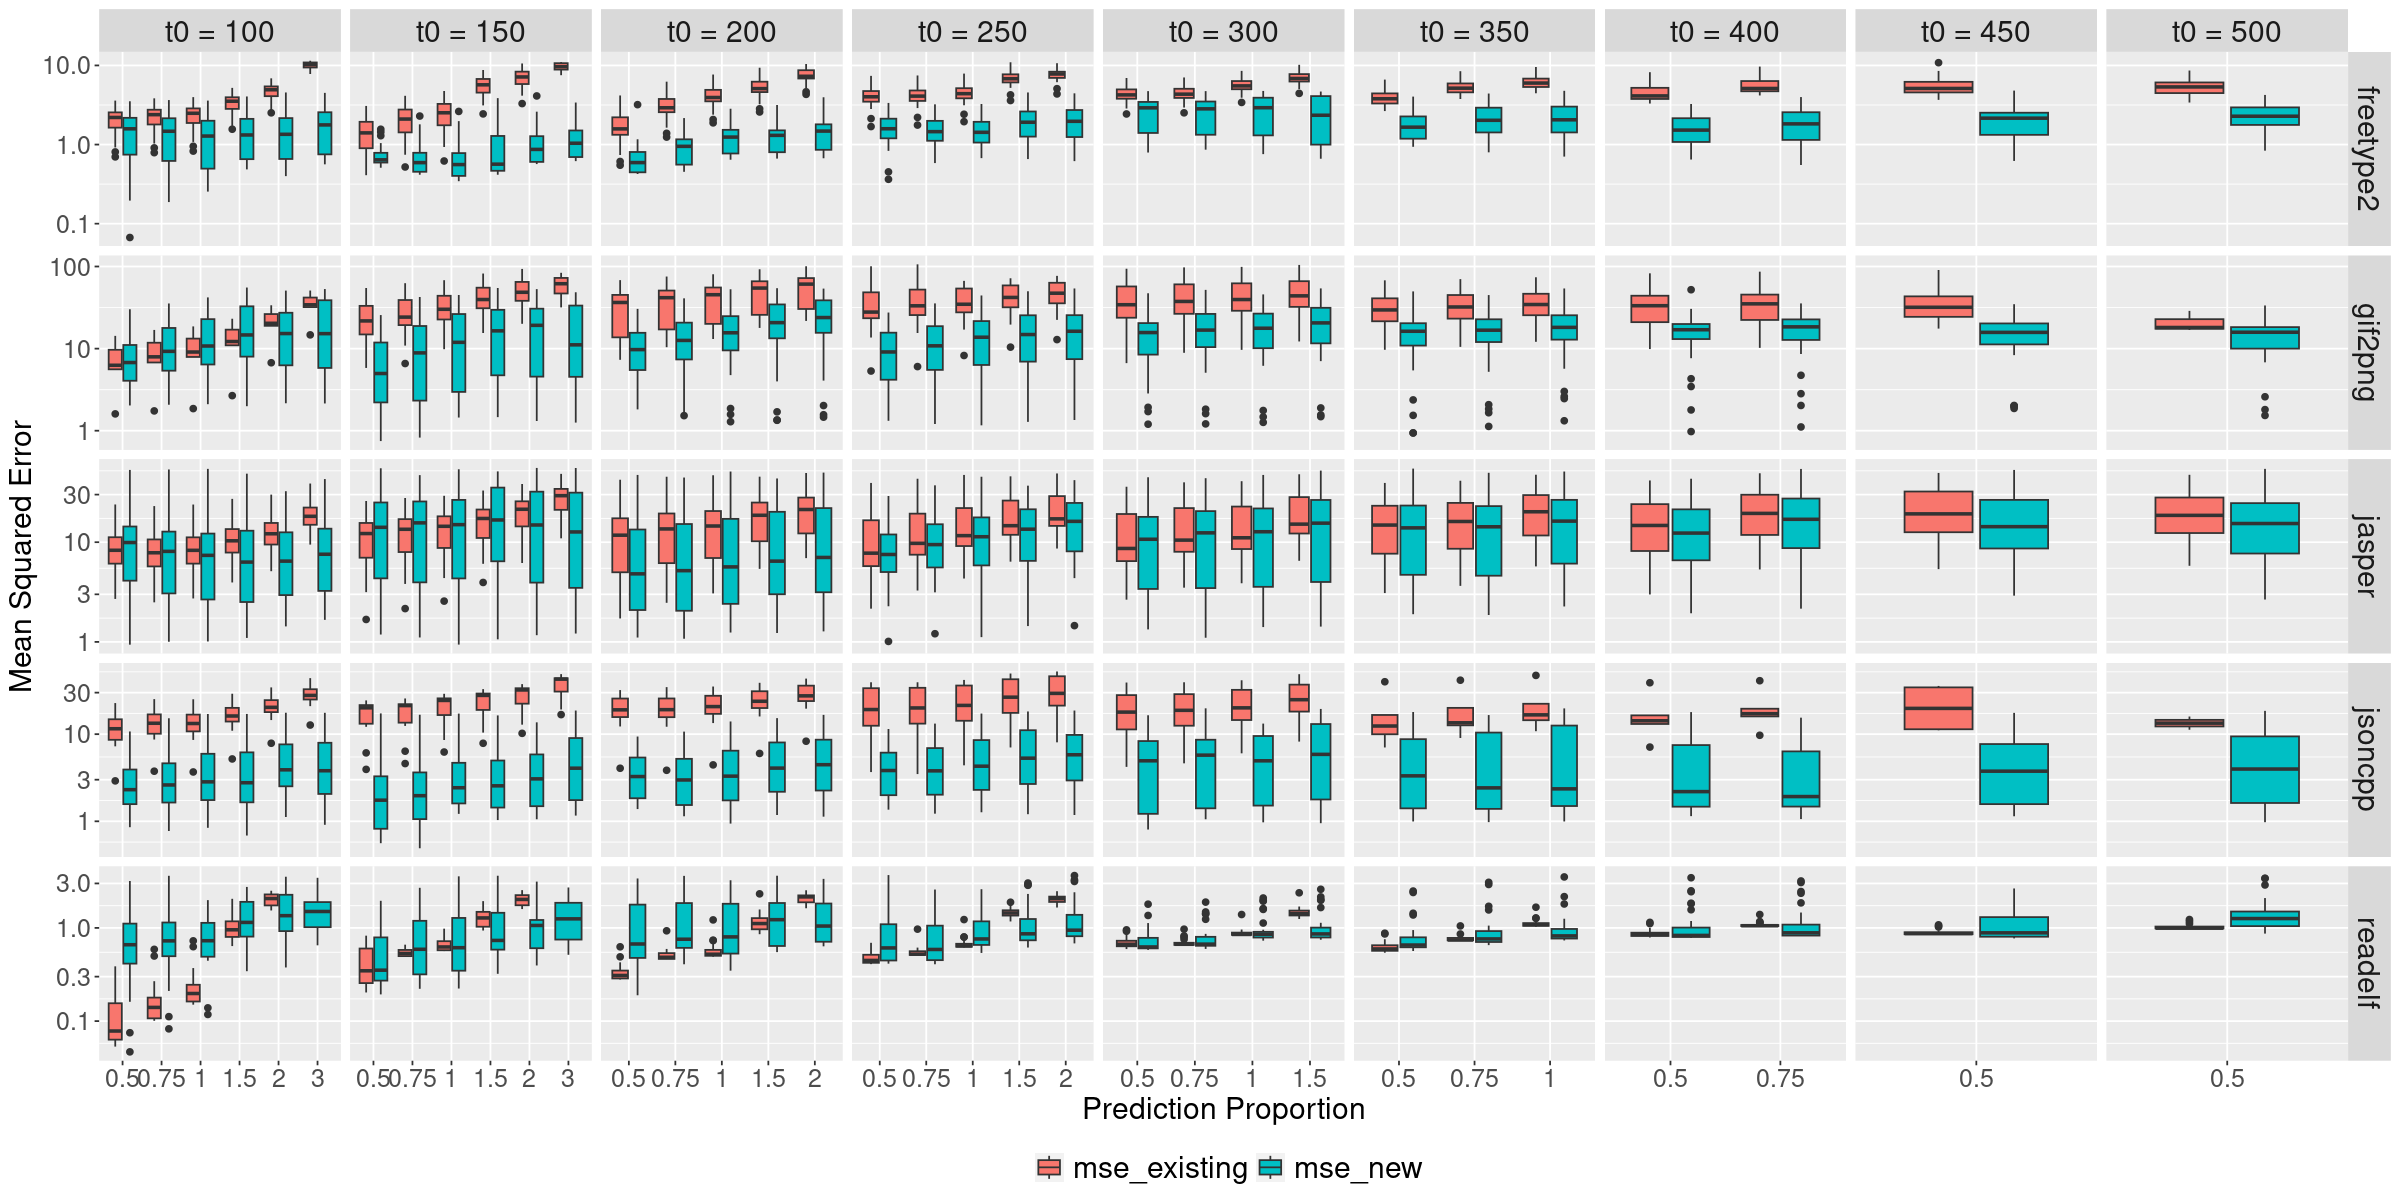

In [15]:
## Compute Mean Squared Error
mse_result = extrapolated %>% 
            filter(delta_existing>0 | delta_new>0,,theta0>=100) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new)) %>%
            merge(gt_data %>% filter(ground>0) %>% mutate(ground=log(ground)),by=c("subject","theta"),all.x=TRUE) %>%
            drop_na() %>% 
            group_by(subject,run,theta0,prop) %>%
            summarize(mse_existing=mean((delta_existing-ground)^2),mse_new=mean((delta_new-ground)^2)) %>%
            ungroup()

mse_result = mse_result %>%
                filter((theta0+prop*theta0)<=max(theta0)) %>%
                group_by(subject,theta0,prop) %>%
                pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
                ungroup()

options(repr.plot.width = 20, repr.plot.height = 10)

p1 = mse_result %>%
        filter(method=="mse_existing" | method=="mse_new") %>%
        filter_all(all_vars(!is.infinite(.))) %>% 
        arrange(theta0) %>%
        mutate(prop=factor(prop),theta0=factor(paste("t0 = ",theta0,sep=""),c(paste("t0 = ",seq(50,500,by=50),sep="")))) %>%
        group_by(subject,method) %>%
        filter(value<as.numeric(quantile(value,0.75)[1])+IQR(value)*1.5) %>%
        ungroup() %>%
        ggplot() +
        geom_boxplot(aes(x=prop,y=value,fill=method)) +
        labs(x="Prediction Proportion") +
        theme(legend.title = element_blank(),legend.position = "bottom",
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=18),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
        scale_y_log10("Mean Squared Error") + 
        facet_grid(subject~theta0,scales="free")

plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Figure-8.pdf",width=20,height=15)

`summarise()` has grouped output by 'subject', 'theta0'. You can override using
the `.groups` argument.


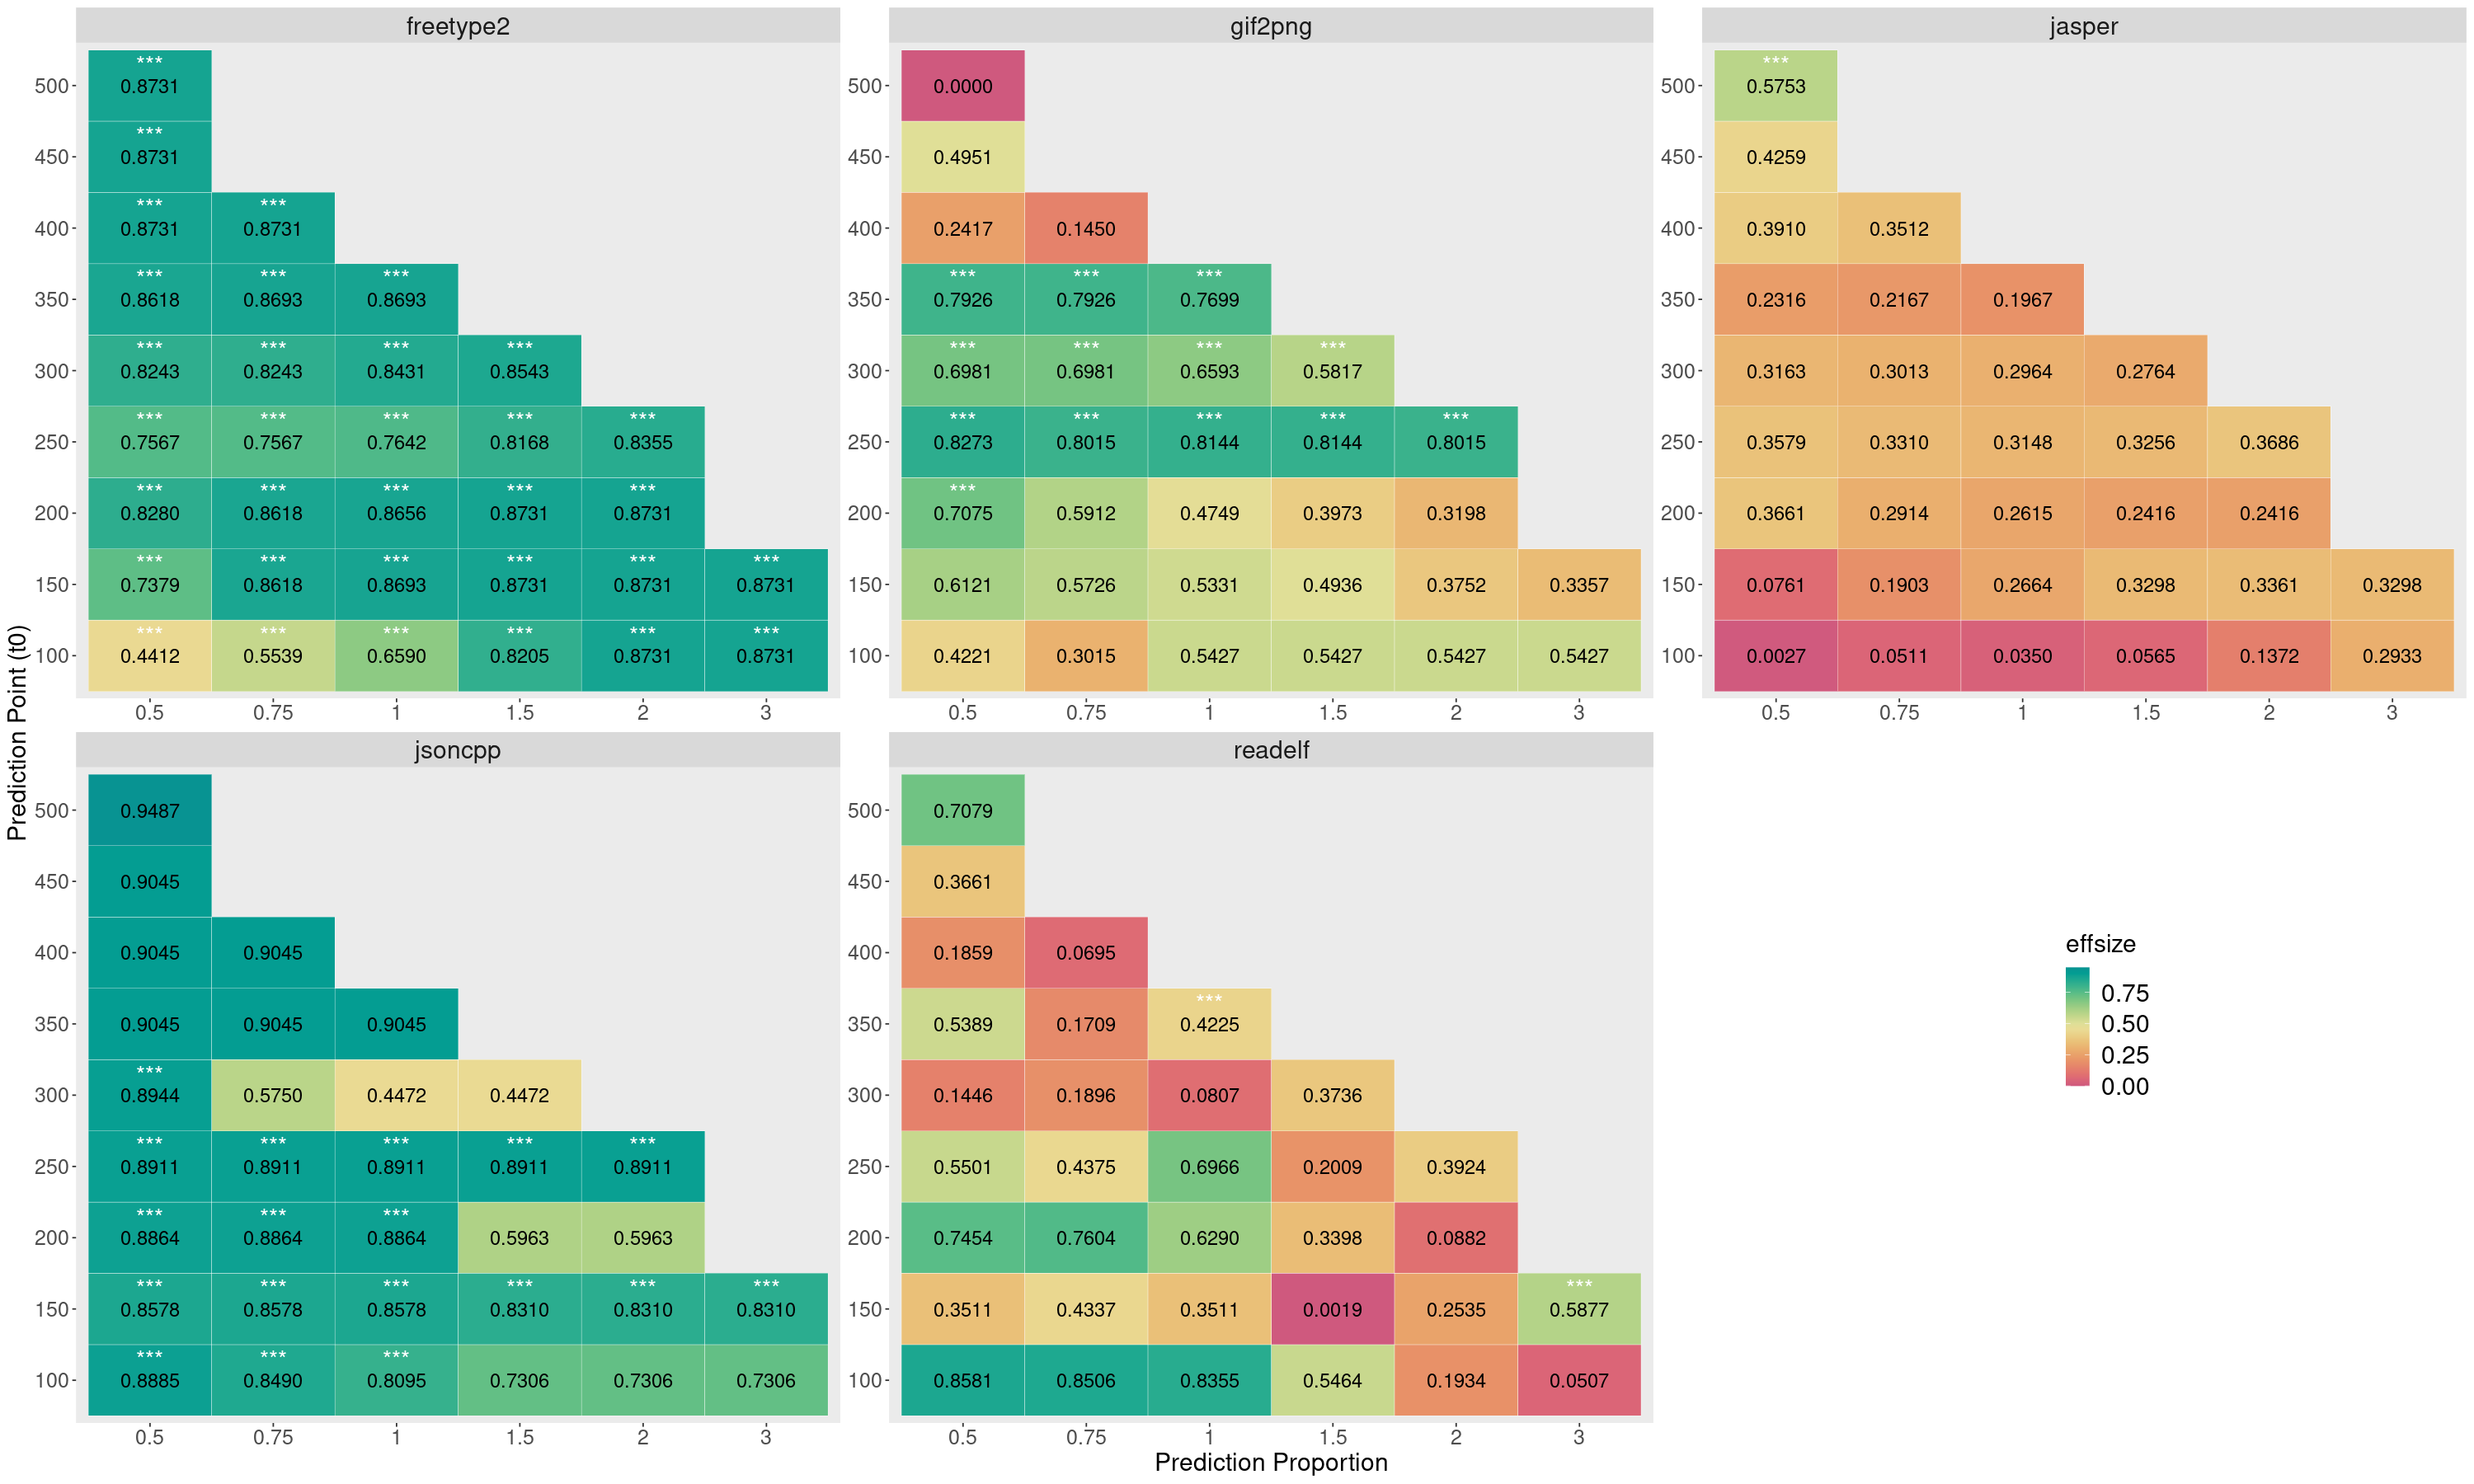

In [16]:
# Heat map
eff_size = merge(
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            wilcox_effsize(value ~ method,alternate="greater",paired=TRUE,conf.level=0.99) %>%
            ungroup() %>%
            select(subject,theta0,prop,effsize),
            mse_result %>% 
            filter(method=="mse_existing" | method=="mse_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            summarise(p.value=wilcox.test(value ~ method,alternative="greater",paired=TRUE,conf.level=0.99)$p.value) %>%
            ungroup(),
            by=c("subject","theta0","prop"))

eff_size$theta0 = factor(eff_size$theta0, levels=seq(50,max(gb_data$theta),by=50))
eff_size$prop = factor(eff_size$prop, levels=c(0.5,0.75,1,1.5,2,3))

options(repr.plot.width = 25, repr.plot.height = 15)
pp = eff_size %>%
    rename(t0=theta0,proportion=prop) %>%
    ggplot(aes(x = proportion, y = t0, fill = effsize)) +
    geom_tile(color="white") +
    geom_text(aes(label = format(effsize, scientific = FALSE, digits = 2)), color = "black", size = 5) +
    geom_text(aes(label = ifelse(p.value<=0.01,"***","")), color = "white", size = 6, vjust = -0.7) +
    scale_fill_gradientn(colors = hcl.colors(20, "Temps", rev = TRUE)) +
    theme(panel.border = element_blank(), panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
         axis.text.x=element_text(size=15),strip.text.x = element_text(size=18),
         axis.title.x=element_text(size=18),strip.text.y = element_text(size=18),
         axis.text.y=element_text(size=15),
         axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         legend.title=element_text(size=18),legend.position=c(0.85,0.3)) +
    xlab("Prediction Proportion") + 
    ylab("Prediction Point (t0)") +
    facet_wrap(~subject,scales="free")

plot_grid(pp, ncol = 1, align = "v")
ggsave("../figures/Figure-9.pdf",width=20,height=15)